    Attribute Information:

    Matrix column entries (attributes):
    name - ASCII subject name and recording number
    MDVP:Fo(Hz) - Average vocal fundamental frequency
    MDVP:Fhi(Hz) - Maximum vocal fundamental frequency
    MDVP:Flo(Hz) - Minimum vocal fundamental frequency
    MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP - Several 
    measures of variation in fundamental frequency
    MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA - Several measures of variation in amplitude
    NHR,HNR - Two measures of ratio of noise to tonal components in the voice
    status - Health status of the subject (one) - Parkinson's, (zero) - healthy
    RPDE,D2 - Two nonlinear dynamical complexity measures
    DFA - Signal fractal scaling exponent
    spread1,spread2,PPE - Three nonlinear measures of fundamental frequency variation 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import to_graphviz, plot_importance

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import _hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor, HistGradientBoostingRegressor
%matplotlib inline

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error, mean_squared_error,r2_score
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve,accuracy_score

import keras
from keras.models import save_model, Sequential
from keras.layers import Activation, BatchNormalization, Dense
from keras.optimizers import Adam

pd.options.display.max_columns= None
#pd.options.display.max_rows = None

Using TensorFlow backend.


### Data Exploration

In [2]:
df = pd.read_csv("parkinsons.data",low_memory=False)

In [3]:
df

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,0.426,0.02182,0.03130,0.02971,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,0.626,0.03134,0.04518,0.04368,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,0.482,0.02757,0.03858,0.03590,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,0.517,0.02924,0.04005,0.03772,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,0.584,0.03490,0.04825,0.04465,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,phon_R01_S50_2,174.188,230.978,94.261,0.00459,0.00003,0.00263,0.00259,0.00790,0.04087,0.405,0.02336,0.02498,0.02745,0.07008,0.02764,19.517,0,0.448439,0.657899,-6.538586,0.121952,2.657476,0.133050
191,phon_R01_S50_3,209.516,253.017,89.488,0.00564,0.00003,0.00331,0.00292,0.00994,0.02751,0.263,0.01604,0.01657,0.01879,0.04812,0.01810,19.147,0,0.431674,0.683244,-6.195325,0.129303,2.784312,0.168895
192,phon_R01_S50_4,174.688,240.005,74.287,0.01360,0.00008,0.00624,0.00564,0.01873,0.02308,0.256,0.01268,0.01365,0.01667,0.03804,0.10715,17.883,0,0.407567,0.655683,-6.787197,0.158453,2.679772,0.131728
193,phon_R01_S50_5,198.764,396.961,74.904,0.00740,0.00004,0.00370,0.00390,0.01109,0.02296,0.241,0.01265,0.01321,0.01588,0.03794,0.07223,19.020,0,0.451221,0.643956,-6.744577,0.207454,2.138608,0.123306


In [4]:
df.drop(['name'],axis=1,inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MDVP:Fo(Hz)       195 non-null    float64
 1   MDVP:Fhi(Hz)      195 non-null    float64
 2   MDVP:Flo(Hz)      195 non-null    float64
 3   MDVP:Jitter(%)    195 non-null    float64
 4   MDVP:Jitter(Abs)  195 non-null    float64
 5   MDVP:RAP          195 non-null    float64
 6   MDVP:PPQ          195 non-null    float64
 7   Jitter:DDP        195 non-null    float64
 8   MDVP:Shimmer      195 non-null    float64
 9   MDVP:Shimmer(dB)  195 non-null    float64
 10  Shimmer:APQ3      195 non-null    float64
 11  Shimmer:APQ5      195 non-null    float64
 12  MDVP:APQ          195 non-null    float64
 13  Shimmer:DDA       195 non-null    float64
 14  NHR               195 non-null    float64
 15  HNR               195 non-null    float64
 16  status            195 non-null    int64  
 1

In [6]:
df.describe()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,154.228641,197.104918,116.324631,0.006220,0.000044,0.003306,0.003446,0.009920,0.029709,0.282251,0.015664,0.017878,0.024081,0.046993,0.024847,21.885974,0.753846,0.498536,0.718099,-5.684397,0.226510,2.381826,0.206552
std,41.390065,91.491548,43.521413,0.004848,0.000035,0.002968,0.002759,0.008903,0.018857,0.194877,0.010153,0.012024,0.016947,0.030459,0.040418,4.425764,0.431878,0.103942,0.055336,1.090208,0.083406,0.382799,0.090119
min,88.333000,102.145000,65.476000,0.001680,0.000007,0.000680,0.000920,0.002040,0.009540,0.085000,0.004550,0.005700,0.007190,0.013640,0.000650,8.441000,0.000000,0.256570,0.574282,-7.964984,0.006274,1.423287,0.044539
25%,117.572000,134.862500,84.291000,0.003460,0.000020,0.001660,0.001860,0.004985,0.016505,0.148500,0.008245,0.009580,0.013080,0.024735,0.005925,19.198000,1.000000,0.421306,0.674758,-6.450096,0.174351,2.099125,0.137451
50%,148.790000,175.829000,104.315000,0.004940,0.000030,0.002500,0.002690,0.007490,0.022970,0.221000,0.012790,0.013470,0.018260,0.038360,0.011660,22.085000,1.000000,0.495954,0.722254,-5.720868,0.218885,2.361532,0.194052
75%,182.769000,224.205500,140.018500,0.007365,0.000060,0.003835,0.003955,0.011505,0.037885,0.350000,0.020265,0.022380,0.029400,0.060795,0.025640,25.075500,1.000000,0.587562,0.761881,-5.046192,0.279234,2.636456,0.252980
max,260.105000,592.030000,239.170000,0.033160,0.000260,0.021440,0.019580,0.064330,0.119080,1.302000,0.056470,0.079400,0.137780,0.169420,0.314820,33.047000,1.000000,0.685151,0.825288,-2.434031,0.450493,3.671155,0.527367


In [7]:
df.isnull().sum()

MDVP:Fo(Hz)         0
MDVP:Fhi(Hz)        0
MDVP:Flo(Hz)        0
MDVP:Jitter(%)      0
MDVP:Jitter(Abs)    0
MDVP:RAP            0
MDVP:PPQ            0
Jitter:DDP          0
MDVP:Shimmer        0
MDVP:Shimmer(dB)    0
Shimmer:APQ3        0
Shimmer:APQ5        0
MDVP:APQ            0
Shimmer:DDA         0
NHR                 0
HNR                 0
status              0
RPDE                0
DFA                 0
spread1             0
spread2             0
D2                  0
PPE                 0
dtype: int64

In [8]:
df.duplicated().sum()

0

In [9]:
df.shape

(195, 23)

In [10]:
df.corr()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
MDVP:Fo(Hz),1.000000,0.400985,0.596546,-0.118003,-0.382027,-0.076194,-0.112165,-0.076213,-0.098374,-0.073742,-0.094717,-0.070682,-0.077774,-0.094732,-0.021981,0.059144,-0.383535,-0.383894,-0.446013,-0.413738,-0.249450,0.177980,-0.372356
MDVP:Fhi(Hz),0.400985,1.000000,0.084951,0.102086,-0.029198,0.097177,0.091126,0.097150,0.002281,0.043465,-0.003743,-0.009997,0.004937,-0.003733,0.163766,-0.024893,-0.166136,-0.112404,-0.343097,-0.076658,-0.002954,0.176323,-0.069543
MDVP:Flo(Hz),0.596546,0.084951,1.000000,-0.139919,-0.277815,-0.100519,-0.095828,-0.100488,-0.144543,-0.119089,-0.150747,-0.101095,-0.107293,-0.150737,-0.108670,0.210851,-0.380200,-0.400143,-0.050406,-0.394857,-0.243829,-0.100629,-0.340071
MDVP:Jitter(%),-0.118003,0.102086,-0.139919,1.000000,0.935714,0.990276,0.974256,0.990276,0.769063,0.804289,0.746625,0.725561,0.758255,0.746635,0.906959,-0.728165,0.278220,0.360673,0.098572,0.693577,0.385123,0.433434,0.721543
MDVP:Jitter(Abs),-0.382027,-0.029198,-0.277815,0.935714,1.000000,0.922911,0.897778,0.922913,0.703322,0.716601,0.697153,0.648961,0.648793,0.697170,0.834972,-0.656810,0.338653,0.441839,0.175036,0.735779,0.388543,0.310694,0.748162
MDVP:RAP,-0.076194,0.097177,-0.100519,0.990276,0.922911,1.000000,0.957317,1.000000,0.759581,0.790652,0.744912,0.709927,0.737455,0.744919,0.919521,-0.721543,0.266668,0.342140,0.064083,0.648328,0.324407,0.426605,0.670999
MDVP:PPQ,-0.112165,0.091126,-0.095828,0.974256,0.897778,0.957317,1.000000,0.957319,0.797826,0.839239,0.763580,0.786780,0.804139,0.763592,0.844604,-0.731510,0.288698,0.333274,0.196301,0.716489,0.407605,0.412524,0.769647
Jitter:DDP,-0.076213,0.097150,-0.100488,0.990276,0.922913,1.000000,0.957319,1.000000,0.759555,0.790621,0.744894,0.709907,0.737439,0.744901,0.919548,-0.721494,0.266646,0.342079,0.064026,0.648328,0.324377,0.426556,0.671005
MDVP:Shimmer,-0.098374,0.002281,-0.144543,0.769063,0.703322,0.759581,0.797826,0.759555,1.000000,0.987258,0.987625,0.982835,0.950083,0.987626,0.722194,-0.835271,0.367430,0.447424,0.159954,0.654734,0.452025,0.507088,0.693771
MDVP:Shimmer(dB),-0.073742,0.043465,-0.119089,0.804289,0.716601,0.790652,0.839239,0.790621,0.987258,1.000000,0.963198,0.973751,0.960977,0.963202,0.744477,-0.827805,0.350697,0.410684,0.165157,0.652547,0.454314,0.512233,0.695058


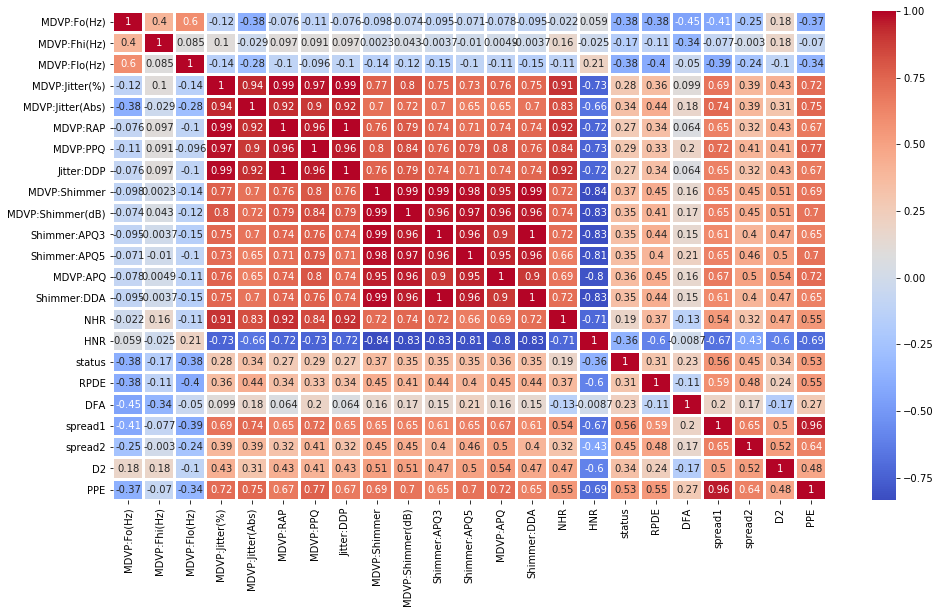

In [11]:
plt.figure(figsize=(16,9))
sns.heatmap(df.corr(),cmap="coolwarm",annot=True,linewidths=2)
plt.show()

### Data Preprocessing

In [12]:
df2 = df[['MDVP:Fo(Hz)','MDVP:Fhi(Hz)','MDVP:Flo(Hz)', 'MDVP:Jitter(%)','MDVP:Jitter(Abs)',
          'MDVP:RAP','MDVP:PPQ','Jitter:DDP','MDVP:Shimmer','MDVP:Shimmer(dB)','Shimmer:APQ3',
          'Shimmer:APQ5' ,'MDVP:APQ','Shimmer:DDA','NHR','HNR','RPDE','DFA',
          'spread1' ,'spread2','D2','PPE','status']]

In [13]:
df2

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE,status
0,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,0.426,0.02182,0.03130,0.02971,0.06545,0.02211,21.033,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654,1
1,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,0.626,0.03134,0.04518,0.04368,0.09403,0.01929,19.085,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674,1
2,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,0.482,0.02757,0.03858,0.03590,0.08270,0.01309,20.651,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634,1
3,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,0.517,0.02924,0.04005,0.03772,0.08771,0.01353,20.644,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975,1
4,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,0.584,0.03490,0.04825,0.04465,0.10470,0.01767,19.649,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,174.188,230.978,94.261,0.00459,0.00003,0.00263,0.00259,0.00790,0.04087,0.405,0.02336,0.02498,0.02745,0.07008,0.02764,19.517,0.448439,0.657899,-6.538586,0.121952,2.657476,0.133050,0
191,209.516,253.017,89.488,0.00564,0.00003,0.00331,0.00292,0.00994,0.02751,0.263,0.01604,0.01657,0.01879,0.04812,0.01810,19.147,0.431674,0.683244,-6.195325,0.129303,2.784312,0.168895,0
192,174.688,240.005,74.287,0.01360,0.00008,0.00624,0.00564,0.01873,0.02308,0.256,0.01268,0.01365,0.01667,0.03804,0.10715,17.883,0.407567,0.655683,-6.787197,0.158453,2.679772,0.131728,0
193,198.764,396.961,74.904,0.00740,0.00004,0.00370,0.00390,0.01109,0.02296,0.241,0.01265,0.01321,0.01588,0.03794,0.07223,19.020,0.451221,0.643956,-6.744577,0.207454,2.138608,0.123306,0


In [14]:
df2.shape

(195, 23)

In [15]:
X = df2.iloc[:,0:22]
y = df2.iloc[:,22]

In [16]:
scaler = MinMaxScaler()

In [17]:
X_scaled = scaler.fit_transform(X)

In [18]:
X_scaled

array([[0.18430827, 0.11259173, 0.05481479, ..., 0.58576513, 0.39066128,
        0.4973096 ],
       [0.19832685, 0.09493044, 0.2783228 , ..., 0.74133704, 0.47314522,
        0.67132602],
       [0.16503854, 0.05912816, 0.26528838, ..., 0.68637091, 0.40881938,
        0.59668246],
       ...,
       [0.50273036, 0.28141298, 0.05072714, ..., 0.34257652, 0.55896743,
        0.18057983],
       [0.6428929 , 0.60180655, 0.05427936, ..., 0.45288473, 0.31822198,
        0.16313677],
       [0.73327434, 0.32279413, 0.07194837, ..., 0.41509481, 0.50367281,
        0.21545975]])

In [19]:
y.values

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int64)

### Model Training

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)

In [21]:
X_train.shape, X_test.shape, y_train.shape

((136, 22), (59, 22), (136,))

In [22]:
xgb = XGBClassifier(random_state=7, n_estimators=100, objective='binary:logistic')

In [23]:
xgb.fit(X_train,y_train,eval_set=[(X_test,y_test)],eval_metric='error',early_stopping_rounds=20)

[0]	validation_0-error:0.067797
Will train until validation_0-error hasn't improved in 20 rounds.
[1]	validation_0-error:0.067797
[2]	validation_0-error:0.067797
[3]	validation_0-error:0.101695
[4]	validation_0-error:0.084746
[5]	validation_0-error:0.101695
[6]	validation_0-error:0.101695
[7]	validation_0-error:0.101695
[8]	validation_0-error:0.101695
[9]	validation_0-error:0.101695
[10]	validation_0-error:0.118644
[11]	validation_0-error:0.101695
[12]	validation_0-error:0.118644
[13]	validation_0-error:0.118644
[14]	validation_0-error:0.101695
[15]	validation_0-error:0.118644
[16]	validation_0-error:0.101695
[17]	validation_0-error:0.101695
[18]	validation_0-error:0.101695
[19]	validation_0-error:0.101695
[20]	validation_0-error:0.101695
Stopping. Best iteration:
[0]	validation_0-error:0.067797



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=7,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [24]:
y_pred = xgb.predict(X_test)

In [25]:
y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0], dtype=int64)

### Model Evaluation

In [26]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83        12
           1       0.96      0.96      0.96        47

    accuracy                           0.93        59
   macro avg       0.90      0.90      0.90        59
weighted avg       0.93      0.93      0.93        59



In [27]:
accuracy_score(y_test,y_pred)

0.9322033898305084